In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
cretaceous = pd.read_csv("cretaceous_wells.csv")
cretaceous.set_index("Unnamed: 0", inplace = True)

In [4]:
cretaceous.head()

,Company Number,Formation,Surface northing,Bottom hole northing,Surface easting,Bottom hole easting,Number of frac stages,Total slurry (bbl),Total proppant (lb),Lateral length (ft),Lateral azimuth (),IP oil (bbl),IP GOR,Cumulative oil (bbl),Cumulative days,IP oil API gravity ()
Unnamed: 0,,,,,,,,,,,,,,,,
0,26,Turner,1.101721,1.101830,1.051392,1.051227,NaN,NaN,NaN,3831,75,96.0,0.0,784,185,NaN
1,9,Turner,1.091999,1.092278,1.056680,1.056723,NaN,NaN,125124.0,3533,339,NaN,NaN,116902,1590,NaN
2,8,Turner,1.088332,1.088023,1.054312,1.054274,12.0,NaN,1992847.0,3754,163,472.0,7.5,157218,3024,52.2
3,8,Turner,1.088317,1.088018,1.054622,1.054559,13.0,36638.0,1992421.0,4000,152,183.0,11.0,109167,2832,NaN
4,8,Turner,1.088386,1.088670,1.054247,1.054335,13.0,NaN,2027081.0,4072,322,232.0,9.1,79701,2634,NaN


In [5]:
heatmapDF = pd.DataFrame(data = {'Formation': cretaceous['Formation'],'Surface northing': cretaceous['Surface northing'], 'Surface easting':cretaceous['Surface easting']})

In [6]:
scores = cretaceous['Cumulative oil (bbl)']/cretaceous['Cumulative days']/cretaceous['Lateral length (ft)']

In [7]:
heatmapDF['scores'] = round(scores, 3)

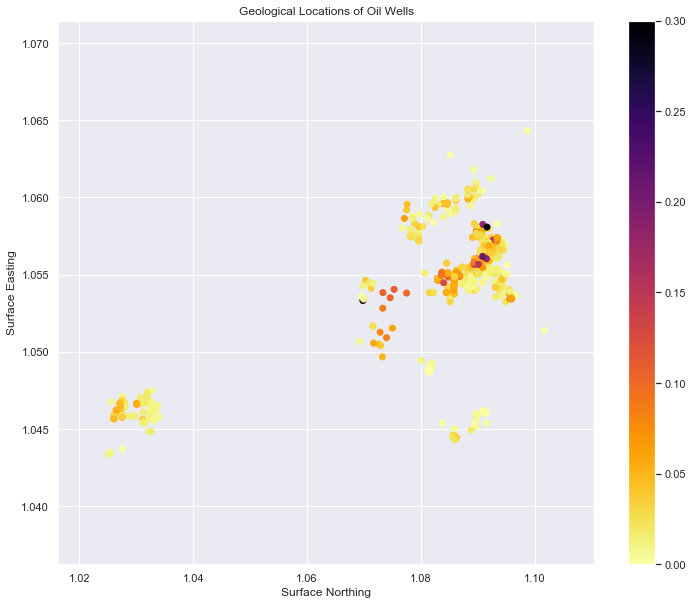

In [18]:
plt.figure(figsize = (12,10))
sns.set()
fig1 = plt.scatter(x = heatmapDF['Surface northing'], y = heatmapDF['Surface easting'], c = heatmapDF['scores'], cmap = 'inferno_r')
plt.xlabel('Surface Northing')
plt.ylabel('Surface Easting')
plt.title('Geological Locations of Oil Wells')
plt.colorbar(fig1)
plt.show()

In [9]:
quadrant1 = heatmapDF[(heatmapDF['Surface northing'] >= 1.08) & (heatmapDF['Surface northing'] <= 1.1) & (heatmapDF['Surface easting'] >= 1.055) & (heatmapDF['Surface easting'] <= 1.06)]
quadrant2 = heatmapDF[(heatmapDF['Surface northing'] >= 1.06) & (heatmapDF['Surface northing'] <= 1.08) & (heatmapDF['Surface easting'] >= 1.055) & (heatmapDF['Surface easting'] <= 1.06)]
quadrant3 = heatmapDF[(heatmapDF['Surface northing'] >= 1.06) & (heatmapDF['Surface northing'] <= 1.08) & (heatmapDF['Surface easting'] >= 1.05) & (heatmapDF['Surface easting'] <= 1.055)]
quadrant4 = heatmapDF[(heatmapDF['Surface northing'] >= 1.08) & (heatmapDF['Surface northing'] <= 1.1) & (heatmapDF['Surface easting'] >= 1.05) & (heatmapDF['Surface easting'] <= 1.055)]

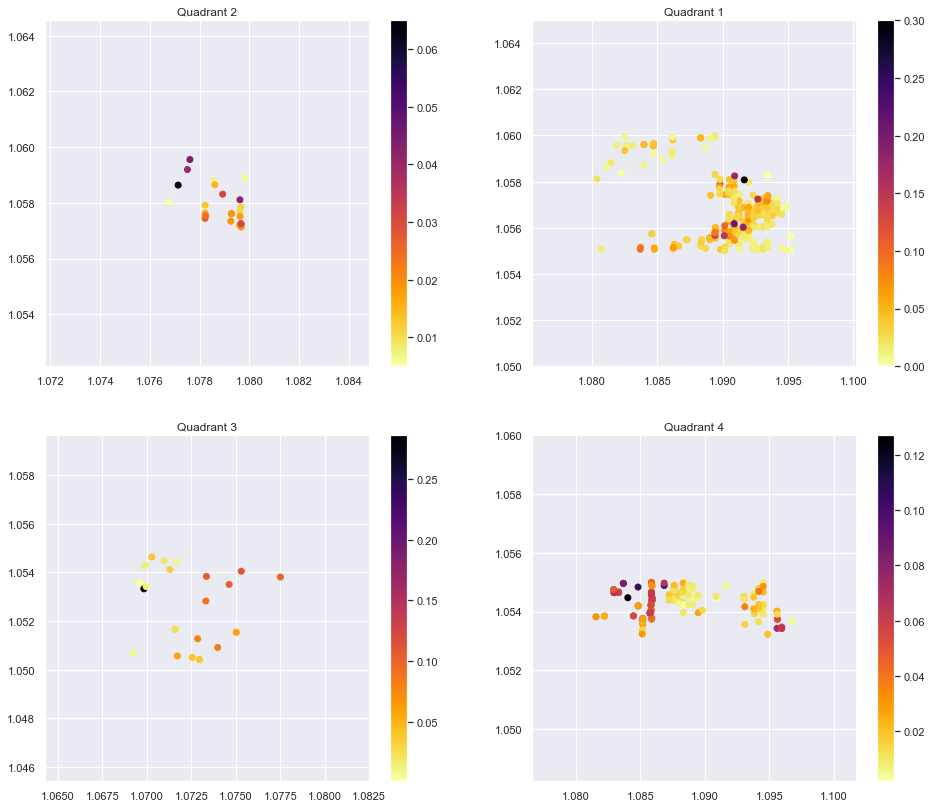

In [19]:
quadrants = [quadrant2, quadrant1, quadrant3, quadrant4]
titles = ['Quadrant 2', 'Quadrant 1', 'Quadrant 3', 'Quadrant 4']

index = 1
plt.figure(figsize = (16, 14))
for quadrant in quadrants:
    plt.subplot(2, 2, index)
    plt.xlim((min(quadrant['Surface northing'])-.005), (max(quadrant['Surface northing'])+.005))
    plt.ylim((min(quadrant['Surface easting'])-.005), (max(quadrant['Surface easting'])+.005))
    plt.title(titles[index - 1])
    plt.scatter(quadrant['Surface northing'], quadrant['Surface easting'], c = quadrant['scores'], cmap = 'inferno_r')
    plt.colorbar()
    index += 1

Want to develop an equation that penalizes high values of proppant, slurry, and GOR, and rewards high values of normalized production (barrels/day/lateral foot).

In [11]:
%%latex
$S_{penalty} = (TS / Days_{cumulative}) + (TP / Days_{cumulative}) + (GOR / GOR_{max}) - Production$

<IPython.core.display.Latex object>

In [12]:
scoreDF = pd.DataFrame(data = {'Total Slurry': cretaceous['Total slurry (bbl)'], 'Total Proppant': cretaceous['Total proppant (lb)'], 'IP GOR': cretaceous['IP GOR'], 'Days': cretaceous['Cumulative days']})
scoreDF.dropna(inplace = True)
slurryScores = scoreDF['Total Slurry'] / scoreDF['Days']
slurryScores = slurryScores / max(slurryScores)
proppantScores = scoreDF['Total Proppant'] / scoreDF['Days']
proppantScores = proppantScores / max(proppantScores)
penaltyScores = (slurryScores) + (proppantScores) + (scoreDF['IP GOR'] / max(scoreDF['IP GOR']))

In [13]:
heatmapDF['Penalty'] = penaltyScores
heatmapDF['Total Score'] = heatmapDF['Penalty'] - heatmapDF['scores']

In [23]:
optimizedDF = heatmapDF.dropna()
optimizedDF.head()

,Formation,Surface northing,Surface easting,scores,Penalty,Total Score
Unnamed: 0,,,,,,
3,Turner,1.088317,1.054622,0.010,0.004809,-0.005191
5,Turner,1.088774,1.054242,0.012,0.004862,-0.007138
6,Turner,1.087656,1.054372,0.012,0.004721,-0.007279
7,Turner,1.087630,1.054647,0.019,0.003677,-0.015323
8,Turner,1.089047,1.054241,0.010,0.005347,-0.004653


In [15]:
quadOpt1 = optimizedDF[(optimizedDF['Surface northing'] >= 1.08) & (optimizedDF['Surface northing'] <= 1.1) & (optimizedDF['Surface easting'] >= 1.055) & (optimizedDF['Surface easting'] <= 1.06)]
quadOpt2 = optimizedDF[(optimizedDF['Surface northing'] >= 1.06) & (optimizedDF['Surface northing'] <= 1.08) & (optimizedDF['Surface easting'] >= 1.055) & (optimizedDF['Surface easting'] <= 1.06)]
quadOpt3 = optimizedDF[(optimizedDF['Surface northing'] >= 1.06) & (optimizedDF['Surface northing'] <= 1.08) & (optimizedDF['Surface easting'] >= 1.05) & (optimizedDF['Surface easting'] <= 1.055)]
quadOpt4 = optimizedDF[(optimizedDF['Surface northing'] >= 1.08) & (optimizedDF['Surface northing'] <= 1.1) & (optimizedDF['Surface easting'] >= 1.05) & (optimizedDF['Surface easting'] <= 1.055)]

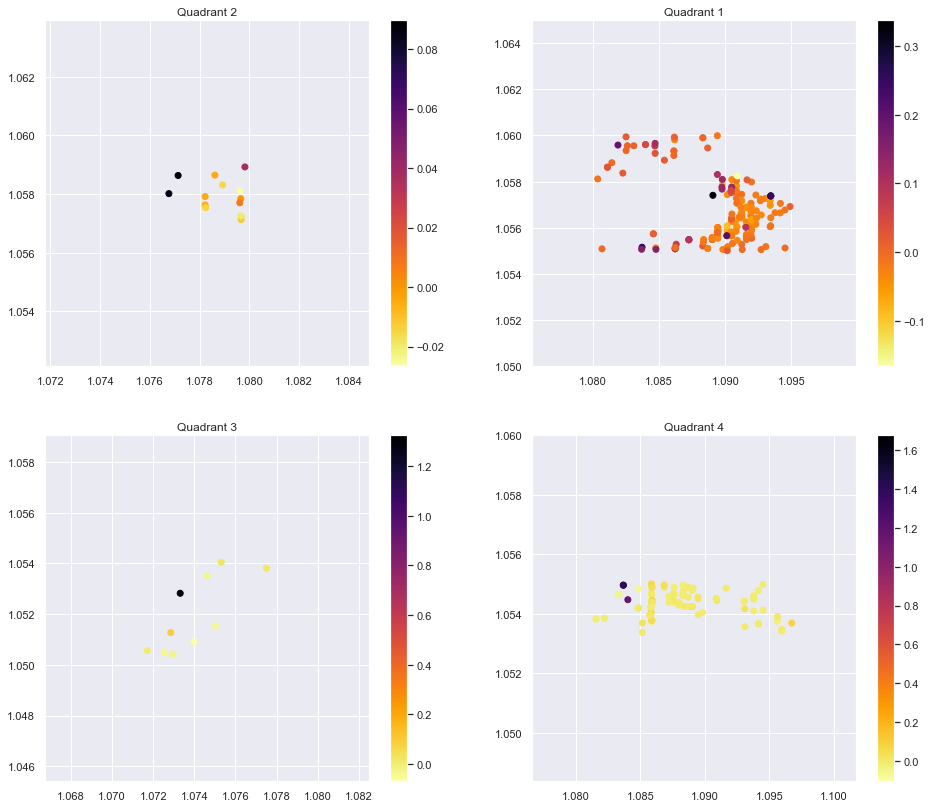

In [22]:
quadOpts = [quadOpt2, quadOpt1, quadOpt3, quadOpt4]
titles = ['Quadrant 2', 'Quadrant 1', 'Quadrant 3', 'Quadrant 4']

index = 1
plt.figure(figsize = (16, 14))
for quadrant in quadOpts:
    plt.subplot(2, 2, index)
    plt.xlim((min(quadrant['Surface northing'])-.005), (max(quadrant['Surface northing'])+.005))
    plt.ylim((min(quadrant['Surface easting'])-.005), (max(quadrant['Surface easting'])+.005))
    plt.title(titles[index - 1])
    plt.scatter(quadrant['Surface northing'], quadrant['Surface easting'], c = quadrant['Total Score'], cmap = 'inferno_r')
    plt.colorbar()
    index += 1